# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# Create training set and define training dataloader
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I have applied two transformation, `ToTensor()`and `Normalization` to the orginal dataset because of the following reasons:
- ToTensor() will help us to convert PIL (Python Image Library) format to PyTorch tensor format, this will allow us to easily manipulate the images as tensors and feed them into a neural network for the next training or inference phase.
- The `normalization` can help us to normalize the data with the mean and standard deviation of the MNIST dataset, this can help us training neural networks more effectively and efficiently. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Train dataset without normalization
6


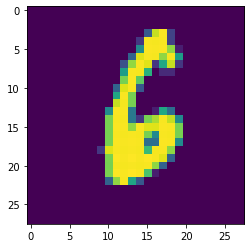

2


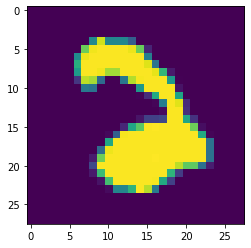

3


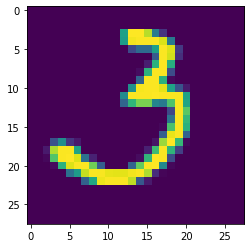

0


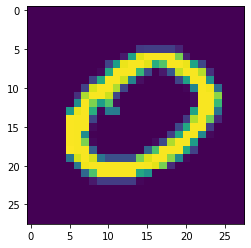

0


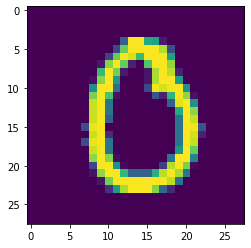

Train dataset with normalization
1


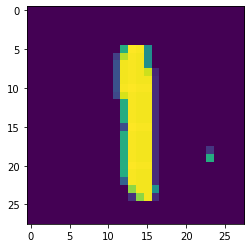

7


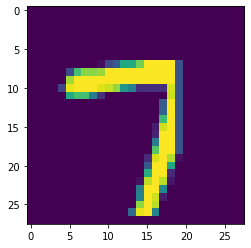

2


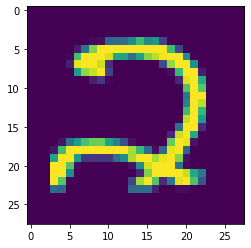

6


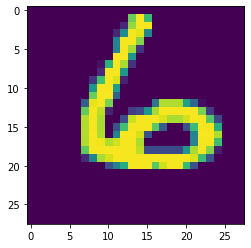

4


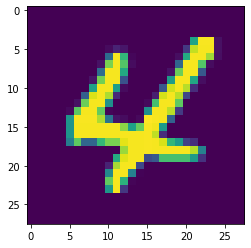

In [5]:
# Explore data
# Visualizing the training dataset with and without normalization 
print("Train dataset without normalization")
transform2 = transforms.Compose([transforms.ToTensor()])
# Create training set and define training dataloader
train_data2 = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transform2)
train_dataloader2 = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
show5(train_dataloader2)
print("Train dataset with normalization")
show5(train_dataloader)

In [6]:
# Explore the shape and size of the data before and after transformation 
#Before the normalization is applied 
#Get the first image 
image, label = next(iter(train_data2))
# size of the image
print("The size of the training image before normalization is applied", image.size())
#After normalization is applied
image, label = next(iter(train_data))
# size of the image
print("The size of the image after normalization is ", image.size())

The size of the training image before normalization is applied torch.Size([1, 28, 28])
The size of the image after normalization is  torch.Size([1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
## YOUR CODE HERE ##
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)
        self.activation = F.relu
    #Define the feed forward neural network architecture 
    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        return x

# Define device usage 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create instance of the new neural network model
model = NeuralNetwork().to(device)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
# Before training the model first we should define loss function and optmizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
# Training the model
n_epochs = 10
model.train()
loss_values = []
accuracy_values = []
for epoch in range(n_epochs):
    run_loss = 0
    run_corrects = 0
    
    for batch_i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
        run_corrects += torch.sum(preds == labels.data)
        
        # Print loss and accuracy for every 250 batchs 
        if batch_i % 250 == 249:
            batch_loss = run_loss /250
            batch_accuracy = run_corrects / (250 * train_dataloader.batch_size)
            print(f"Epoch: {epoch +1 } / {n_epochs}, Batch: {batch_i +1}/{len(train_dataloader)},Loss:{batch_loss:.5f}, Accuracy:{batch_accuracy:.5f}")
            loss_values.append(batch_loss)
            accuracy_values.append(batch_accuracy)
            run_loss = 0
            run_corrects = 0

Epoch: 1 / 10, Batch: 250/938,Loss:1.78833, Accuracy:0.69606
Epoch: 1 / 10, Batch: 500/938,Loss:1.64997, Accuracy:0.82206
Epoch: 1 / 10, Batch: 750/938,Loss:1.61962, Accuracy:0.84925
Epoch: 2 / 10, Batch: 250/938,Loss:1.55982, Accuracy:0.90763
Epoch: 2 / 10, Batch: 500/938,Loss:1.55500, Accuracy:0.91100
Epoch: 2 / 10, Batch: 750/938,Loss:1.54278, Accuracy:0.92338
Epoch: 3 / 10, Batch: 250/938,Loss:1.53123, Accuracy:0.93475
Epoch: 3 / 10, Batch: 500/938,Loss:1.52984, Accuracy:0.93519
Epoch: 3 / 10, Batch: 750/938,Loss:1.52762, Accuracy:0.93744
Epoch: 4 / 10, Batch: 250/938,Loss:1.51727, Accuracy:0.94756
Epoch: 4 / 10, Batch: 500/938,Loss:1.52244, Accuracy:0.94125
Epoch: 4 / 10, Batch: 750/938,Loss:1.52082, Accuracy:0.94294
Epoch: 5 / 10, Batch: 250/938,Loss:1.51323, Accuracy:0.95063
Epoch: 5 / 10, Batch: 500/938,Loss:1.51317, Accuracy:0.95012
Epoch: 5 / 10, Batch: 750/938,Loss:1.51484, Accuracy:0.94888
Epoch: 6 / 10, Batch: 250/938,Loss:1.51044, Accuracy:0.95256
Epoch: 6 / 10, Batch: 50

Plot the training loss (and validation loss/accuracy, if recorded).

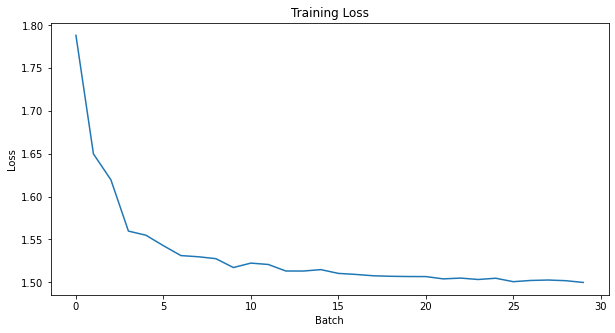

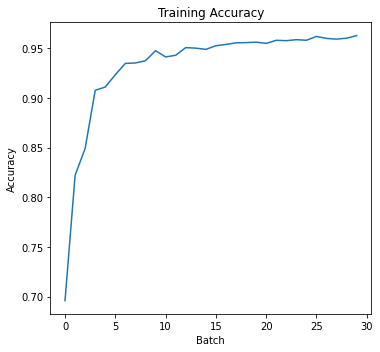

In [10]:
## YOUR CODE HERE ##
#Plot the loss and accuracy

plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.plot(loss_values)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(accuracy_values)
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.tight_layout()

plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##
# Testing model accuracy 
model.eval()
test_corrects = 0
total_samples = 0

for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    test_corrects += torch.sum(preds == labels.data)
    total_samples += len(labels)
    
test_accuracy = test_corrects / total_samples
print(f"Test Accuracy:{test_accuracy:.5f}")

Test Accuracy:0.96700


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [7]:
## YOUR CODE HERE ##
# Changing two hyperparameters, dropout value and epoch can increase the accuracy 
## YOUR CODE HERE ##
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.1)
        self.activation = F.relu
    #Define the feed forward neural network architecture 
    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        return x

# Define device usage 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create instance of the new neural network model
model = NeuralNetwork().to(device)

## YOUR CODE HERE ##
# Before training the model first we should define loss function and optmizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


## YOUR CODE HERE ##
# Training the model
n_epochs = 30
model.train()
loss_values = []
accuracy_values = []
for epoch in range(n_epochs):
    run_loss = 0
    run_corrects = 0
    
    for batch_i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
        run_corrects += torch.sum(preds == labels.data)
        
        # Print loss and accuracy for every 250 batchs 
        if batch_i % 250 == 249:
            batch_loss = run_loss /250
            batch_accuracy = run_corrects / (250 * train_dataloader.batch_size)
            print(f"Epoch: {epoch +1 } / {n_epochs}, Batch: {batch_i +1}/{len(train_dataloader)},Loss:{batch_loss:.5f}, Accuracy:{batch_accuracy:.5f}")
            loss_values.append(batch_loss)
            accuracy_values.append(batch_accuracy)
            run_loss = 0
            run_corrects = 0
            
# Testing model accuracy 
model.eval()
test_corrects = 0
total_samples = 0

for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    test_corrects += torch.sum(preds == labels.data)
    total_samples += len(labels)
    
test_accuracy = test_corrects / total_samples
print(f"Test Accuracy:{test_accuracy:.5f}")

Epoch: 1 / 30, Batch: 250/938,Loss:1.75527, Accuracy:0.73725
Epoch: 1 / 30, Batch: 500/938,Loss:1.66001, Accuracy:0.80831
Epoch: 1 / 30, Batch: 750/938,Loss:1.64774, Accuracy:0.82025
Epoch: 2 / 30, Batch: 250/938,Loss:1.61162, Accuracy:0.85544
Epoch: 2 / 30, Batch: 500/938,Loss:1.55197, Accuracy:0.91531
Epoch: 2 / 30, Batch: 750/938,Loss:1.53860, Accuracy:0.92712
Epoch: 3 / 30, Batch: 250/938,Loss:1.53141, Accuracy:0.93331
Epoch: 3 / 30, Batch: 500/938,Loss:1.52604, Accuracy:0.93837
Epoch: 3 / 30, Batch: 750/938,Loss:1.52191, Accuracy:0.94225
Epoch: 4 / 30, Batch: 250/938,Loss:1.51753, Accuracy:0.94669
Epoch: 4 / 30, Batch: 500/938,Loss:1.51594, Accuracy:0.94819
Epoch: 4 / 30, Batch: 750/938,Loss:1.51182, Accuracy:0.95144
Epoch: 5 / 30, Batch: 250/938,Loss:1.51074, Accuracy:0.95237
Epoch: 5 / 30, Batch: 500/938,Loss:1.50930, Accuracy:0.95412
Epoch: 5 / 30, Batch: 750/938,Loss:1.50697, Accuracy:0.95581
Epoch: 6 / 30, Batch: 250/938,Loss:1.50330, Accuracy:0.96100
Epoch: 6 / 30, Batch: 50

After I simply  changed the number of epochs from 10 to 30 and decrease the dropout value from 0.2 to 0.1 the test accuracy increase from 96.7% to 97.18%.

## Saving your model
Using `torch.save`, save your model for future loading.

In [8]:
## YOUR CODE HERE ##
torch.save(model,'final_mnist_model')